In [ ]:
import os.path # Directories, gotta have em.
import pickle # Better than .csv + a cute name.
import pandas as pd # DataFrames. Looping is easy. Obscure functions are fast.
import numpy as np # do math on vectors with more obscure functions.
import re # one-way encryption for your codebase
import pathlib
from scipy import stats

# Interactive Computing
from timeit import default_timer as tm
import datetime
from tqdm import tqdm

# Spacy
import spacy
from spacy.tokens import Doc, DocBin
nlp = spacy.load('en_core_web_trf')
if Doc.has_extension('name'):
    pass
else:
    Doc.set_extension('name', default=None)

import gensim

In [2]:
persuade_corpus = pd.read_pickle('persuade_corpus_full.pkl')
display(persuade_corpus.essay_id_comp)

0         423A1CA112E2
1         423A1CA112E2
2         423A1CA112E2
3         423A1CA112E2
4         423A1CA112E2
              ...     
285378    DF920E0A7337
285379    DF920E0A7337
285380    DF920E0A7337
285381    DF920E0A7337
285382    DF920E0A7337
Name: essay_id_comp, Length: 285383, dtype: object

In [7]:
spacy_file = 'persuade.spacy'

def proc_texts(text_tuples):
    doc_bin = DocBin(attrs=["ORTH", "TAG", "HEAD", "DEP", "LEMMA", "MORPH", "POS"], store_user_data=True)
    for doc, name in nlp.pipe(text_tuples, as_tuples=True):
        doc._.trf_data = None
        doc._.name = name
#         doc.cats = {} # I can use this to store categories for spacy text categorization later on.
        doc_bin.add(doc)
    return doc_bin

if os.path.isfile(spacy_file):
    doc_bin = DocBin().from_disk(spacy_file)
else:
    doc_bin = proc_texts(text_id_tuples)
    doc_bin.to_disk(spacy_file)
docs = list(tqdm(doc_bin.get_docs(nlp.vocab), total=len(doc_bin)))

100%|██████████| 285383/285383 [01:24<00:00, 3386.66it/s]

85.89


In [8]:
discourse_types = persuade_corpus[['discourse_type']].copy()
display(discourse_types.value_counts().index.get_level_values(0))

Index(['Claim', 'Evidence', 'Unannotated', 'Position', 'Concluding Statement',
       'Lead', 'Counterclaim', 'Rebuttal'],
      dtype='object', name='discourse_type')

In [9]:
simple_texts_file = 'simple_texts_with_stops.pkl'

simple_texts = [] # list of lists of strings
for doc in docs:
    new_doc = [t.lemma_ for t in doc if t.is_alpha]
    simple_texts.append(new_doc)

discourse_types['text'] = simple_texts

In [10]:
for i in range(2,6):
    print(f'Number of discourse unit labels with LESS THAN {str(i)} tokens:')
    display(discourse_types[discourse_types['text'].apply(len) < i]['discourse_type'].value_counts()[:3])
    display(discourse_types[(discourse_types['text'].apply(len) < i) & (discourse_types['discourse_type'].str.match('Claim'))][:5])

Number of discourse unit labels with LESS THAN 2 tokens:


Unannotated    18670
Claim            477
Position           5
Name: discourse_type, dtype: int64

,discourse_type,text
302,Claim,[mentally]
510,Claim,[accident]
1229,Claim,[accident]
2135,Claim,[distraction]
2136,Claim,[swerve]


Number of discourse unit labels with LESS THAN 3 tokens:


Unannotated    25960
Claim           1484
Position          45
Name: discourse_type, dtype: int64

,discourse_type,text
302,Claim,[mentally]
510,Claim,[accident]
534,Claim,"[it, illegal]"
727,Claim,"[injure, people]"
1229,Claim,[accident]


Number of discourse unit labels with LESS THAN 4 tokens:


Unannotated    28714
Claim           2731
Position          99
Name: discourse_type, dtype: int64

,discourse_type,text
90,Claim,"[slow, reaction, time]"
91,Claim,"[and, fatal, injury]"
302,Claim,[mentally]
369,Claim,"[hit, a, pedestrian]"
510,Claim,[accident]


Number of discourse unit labels with LESS THAN 5 tokens:


Unannotated    30308
Claim           4490
Position         248
Name: discourse_type, dtype: int64

,discourse_type,text
13,Claim,"[be, because, bad, wreck]"
15,Claim,"[and, may, cause, death]"
59,Claim,"[it, can, be, illegal]"
90,Claim,"[slow, reaction, time]"
91,Claim,"[and, fatal, injury]"


# Let's Clean this up a bit
I'm going to be conservative and just filter out lists with only one token (less than 2)

We may want to circle back and be more aggressive here.

I'm not clear on how 1-word segments were labelled as claims...

It seems that 2 word segments that contain a verb are likely to be claims, else unannotated.

In [13]:
elements = discourse_types[discourse_types['text'].apply(len) >= 10]
display(elements)

,discourse_type,text
1,Lead,"[modern, human, today, be, always, on, their, ..."
2,Position,"[they, be, some, really, bad, consequence, whe..."
3,Evidence,"[some, certain, area, in, the, United, States,..."
4,Evidence,"[when, people, have, phone, they, know, about,..."
5,Claim,"[driving, be, one, of, the, way, how, to, get,..."
...,...,...
285375,Unannotated,"[first, I, think, it, show, you, more, than, o..."
285376,Evidence,"[one, opinion, of, a, person, might, destroy, ..."
285378,Evidence,"[one, person, can, change, your, option, but, ..."
285380,Evidence,"[have, more, than, one, person, opinion, might..."


In [14]:
display(sum(discourse_types['text'].apply(len)))
display(sum(elements['text'].apply(len)))
display(elements)

10569558

10312743

,discourse_type,text
1,Lead,"[modern, human, today, be, always, on, their, ..."
2,Position,"[they, be, some, really, bad, consequence, whe..."
3,Evidence,"[some, certain, area, in, the, United, States,..."
4,Evidence,"[when, people, have, phone, they, know, about,..."
5,Claim,"[driving, be, one, of, the, way, how, to, get,..."
...,...,...
285375,Unannotated,"[first, I, think, it, show, you, more, than, o..."
285376,Evidence,"[one, opinion, of, a, person, might, destroy, ..."
285378,Evidence,"[one, person, can, change, your, option, but, ..."
285380,Evidence,"[have, more, than, one, person, opinion, might..."


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(elements['text'], elements['discourse_type'], test_size=0.33, random_state=42)
# display(X_train.iloc[[99]])
# display(y_train.iloc[[99]])

# for ind, item in enumerate(X_train[:5].iteritems()):
#     print(item[0])
#     print(item[1])
#     print(y_train.iloc[ind])

In [91]:
def toks_to_tags(texts, labels):
    '''
    texts and labels must have matched indices
    '''
    for ind, text in enumerate(texts.iteritems()):
        yield(gensim.models.doc2vec.TaggedDocument(text[1], [str(text[0])]))
        # yield(gensim.models.doc2vec.TaggedDocument(text[1], [str(text[0]), labels.iloc[ind]]))

train_corpus = list(toks_to_tags(X_train, y_train))
test_corpus = list(toks_to_tags(X_test, y_test))

- [x] Do word2vec first into matrix/dataframe. Check cosine similarities/semantic similarities of sentences.
- [x] Request COCA preloaded vector matrix

- [x] Get word count: 10,569,558 (raw) - 10,552,942 (elements with 2 or more tokens)
- [x] Lemmatize before creating Vocab
   - This appears to make the results worse, but not sure yet. Definitely no improvement.

- [ ] For diagnostic purposes: Get 10 or so discourse elements that are clearly similar and verify that the model agrees that they are similar.

- [ ] Throw it at an RF Classifier.

- [ ] Think about eventually comparing results with spelling corrected and original versions. Might use neurSpell for this.

In [92]:
print(len(train_corpus))
print(train_corpus[1].tags)

149267
['207667']


In [94]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=75, workers=4)
model.build_vocab(train_corpus)
print(f"The size of the model's vocabulary is {len(model.wv):,}.")
print(f"Word 'phone' appeared {model.wv.get_vecattr('phone', 'count')} times in the training corpus.")

The size of the model's vocabulary is 21,077.
Word 'phone' appeared 18636 times in the training corpus.


In [95]:
st = tm()
model.train(train_corpus,
            total_examples=model.corpus_count,
            epochs=model.epochs)
print(datetime.timedelta(seconds=round(tm()-st)))

0:12:36


In [ ]:
print('The number of computed word vectors is...', len(model.wv))
word_vectors = model.wv
print('The word vector for phone is...')
print(word_vectors['phone'])

diag_words = ['phone', 'election', 'help', 'believe', 'argue', 'car', 'drive']

def simmer(diag_words, num_results):
    print()
    for word in diag_words:
        print(f'Most similar words to {word}:')
        for sim_word, score in word_vectors.most_similar(positive=[word])[:num_results]:
            print(sim_word, round(score, 2), end=' -- ')
        print('\n')
        
simmer(diag_words, 4)

print('We also have paragraph or document vectors')
print('The word vector for discourse element 1 is..')
[print(word, end=' ') for word in X_train.iat[1]]
print()
print(model.dv[1])
print()

# print('We also have keyed vectors that are similar to document vectors but represent a label')
# print('The keyed vector for Claim is...')
# print(model.dv['Claim'])

In [84]:
# for text in test_corpus[:5]:
#     print(y_test.iloc[int(text.tags)])
#     print(text.tags)
#     print(X_test.iloc[int(text.tags)])

def diagnosticator(test_corpus, X_train, y_train, debug=False):
    y_pred = []
    y_true = []
    for doc in test_corpus:
        idx = int(doc.tags[0])
        inferred_vector = model.infer_vector(doc.words)
        sims = model.dv.similar_by_vector(inferred_vector, topn=9)

        # pred = int(sims[0][0]) if sims[0][0].isdigit() else sims[0][0]
        pred = next(int(pred[0]) for pred in sims if pred[0].isdigit())
        print(sims)
        print(pred)
#         if debug:
#             print(f'True: {doc.tags[1]}')
#             print('Unseen text:', end='  ')
#             [print(word, end=' ') for word in doc.words]
#             print()
#         if type(pred) == int:
#             pred_label = y_train.at[pred]
#             if debug:
#                 print('Most similar text:', end='  ')
#                 [print(word, end=' ') for word in X_train[pred]]
#                 print()
#                 print(f'Predicted: {pred_label}')
#                 print('---')
#         elif type(pred) == str:
#             pred_label = pred
#             if debug:
#                 print(f'Most similar to keyed vector: {pred}')
#                 print('---')

#         y_true.append(doc.tags[1])
        # y_pred.append(pred_label)
#         second_ranks.append(sims[1])
    return y_true, y_pred

In [156]:
def diagnosticator(X_test, y_test, X_train, y_train, debug=False):
    y_pred = []
    y_true = []
    for ind, doc in tqdm(X_test.iteritems()):
        inferred_vector = model.infer_vector(doc)
        pred = int(model.dv.similar_by_vector(inferred_vector, topn=1)[0][0])
        if debug:
            print(f'True: {y_test.at[ind]}')
            print('Unseen text:', end='  ')
            [print(word, end=' ') for word in doc]
            print()
        if type(pred) == int:
            pred_label = y_train.at[pred]
            if debug:
                print('Most similar text:', end='  ')
                [print(word, end=' ') for word in X_train[pred]]
                print()
                print(f'Predicted: {pred_label}')
                print('---')
        elif type(pred) == str:
            pred_label = pred
            if debug:
                print(f'Most similar to keyed vector: {pred}')
                print('---')

        y_true.append(y_test.at[ind])
        y_pred.append(pred_label)
    return y_true, y_pred

In [ ]:
x, y = diagnosticator(X_test=X_test[:15],
                      y_test=y_test,
                      X_train=X_train,
                      y_train=y_train,
                      debug=True)

In [ ]:
# labels = ['Claim', 'Evidence', 'Unannotated', 'Position', 'Concluding Statement',
#        'Lead', 'Counterclaim', 'Rebuttal']
# for label in labels:
#     print(model.dv.get_index(label, default=None))

In [ ]:
# doc_id = 4

# test = train_corpus[doc_id]
# inferred_vector = model.infer_vector(test.words)
# display(test.tags[0])
# sims = model.dv.most_similar([inferred_vector])
# display(sims)
# rank = [docid for docid, sim in sims].index(test.tags[0])
# display(rank)
# display(sims[1])

In [191]:
# def diagnosticator(texts):
#     y_pred = []
#     y_true = []
# #     second_ranks = []
#     for text in texts:
#         label = text.tags[0]
#         inferred_vector = model.infer_vector(text.words)
#         sims = model.dv.most_similar([inferred_vector], topn=1)
# #         sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
#         pred = sims[0][0]
# #         pred = [docid for docid, sim in sims].index(label)
#         y_true.append(label)
#         y_pred.append(pred)
# #         second_ranks.append(sims[1])
#     return y_true, y_pred

In [157]:
# y_true, y_pred = diagnosticator(tqdm(test_corpus),
#                       X_train=X_train,
#                       y_train=y_train)
y_true, y_pred = diagnosticator(X_test=X_test[:1000],
                                y_test=y_test,
                                X_train=X_train,
                                y_train=y_train)

1000it [00:06, 155.95it/s]


                      precision    recall  f1-score   support

               Claim       0.47      0.55      0.50       303
Concluding Statement       0.23      0.15      0.18       102
        Counterclaim       0.13      0.20      0.16        25
            Evidence       0.60      0.45      0.51       350
                Lead       0.23      0.23      0.23        66
            Position       0.22      0.35      0.27        79
            Rebuttal       0.00      0.00      0.00        22
         Unannotated       0.18      0.21      0.19        53

            accuracy                           0.40      1000
           macro avg       0.26      0.27      0.26      1000
        weighted avg       0.42      0.40      0.40      1000



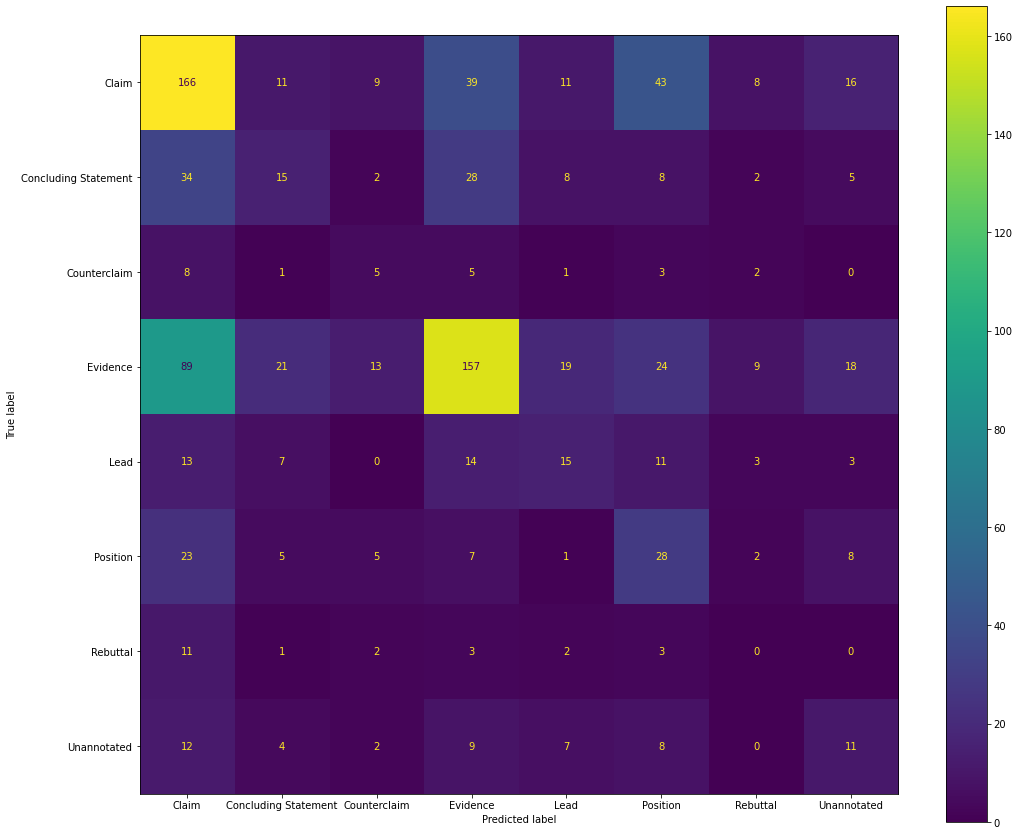

In [158]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (17,15)

# precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='macro')
# display(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {fscore:.2f}')

print(classification_report(y_true, y_pred))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

def heatconmat(y_true,y_pred):
    # sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                # fmt='d',
                cbar=False,
                # cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))
#Fit and predict

lrc = LogisticRegression(C=5, multi_class='multinomial', solver='saga',max_iter=1000)
lrc.fit(X_train_log,y_train)
y_pred = lrc.predict(np.array([model.infer_vector(
    tagged_test[i][0]) for i in range(len(tagged_test))]))
# heatconmat(y_test,y_pred)

In [180]:
# X_train_log = np.array([model.dv[i] for i in range(len(model.dv))])
def vector_retrieval(model, input_docs):
    targets, feature_vectors = zip(*[(doc.tags[0], model[doc.tags[0]]) for doc in input_docs])
    return targets, feature_vectors
def vector_inference(model, input_docs):
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in input_docs])
    return targets, feature_vectors
y_cls_train, X_cls_train = vector_retrieval(model, tqdm(train_corpus))
y_cls_test, X_cls_test = vector_inference(model, tqdm(test_corpus))

100%|██████████| 73521/73521 [04:16<00:00, 287.19it/s]


In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel="linear", C=0.025)
# classifier = LogisticRegression(n_jobs=4, solver='saga')

classifier.fit(X_cls_train, y_cls_train)
y_cls_pred = classifier.predict(X_cls_test)

In [ ]:
print(classification_report(y_cls_test, y_cls_pred))

ConfusionMatrixDisplay.from_predictions(y_cls_test, y_cls_pred)
plt.show()